# Getting data

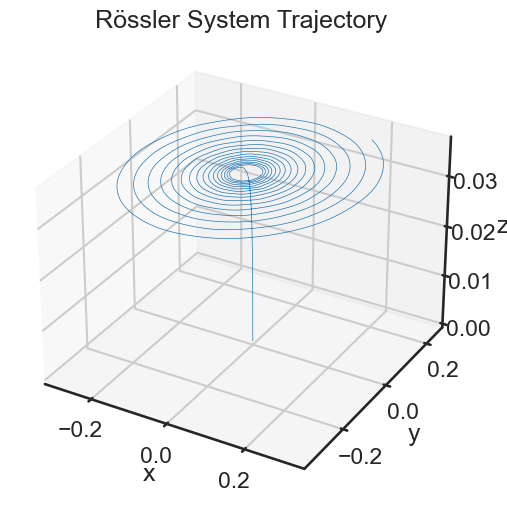

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

def rossler_rhs(t, X, a, b, c):
    x, y, z = X
    dx_dt = -y - z
    dy_dt = x + a * y
    dz_dt = b + z * (x - c)
    return [dx_dt, dy_dt, dz_dt]

# Parameter values
a = 0.05
b = 0.2
c = 5.7

# Time span
t_span = np.linspace(0, 100, 10000)

# Initial conditions
X0 = [0, 0, 0]

# Solve Rössler system
sol = solve_ivp(lambda t, X: rossler_rhs(t, X, a, b, c), [t_span[0], t_span[-1]], X0, t_eval=t_span)

# Extract trajectory data
x = sol.y[0]
y = sol.y[1]
z = sol.y[2]

# Plot trajectory in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rössler System Trajectory')
plt.show()


# rSLDS on normal form of Boutin

## Beta_1 = -0.1 and Beta_2 = -0.1

We have an unstable limit cycle with a sink FP

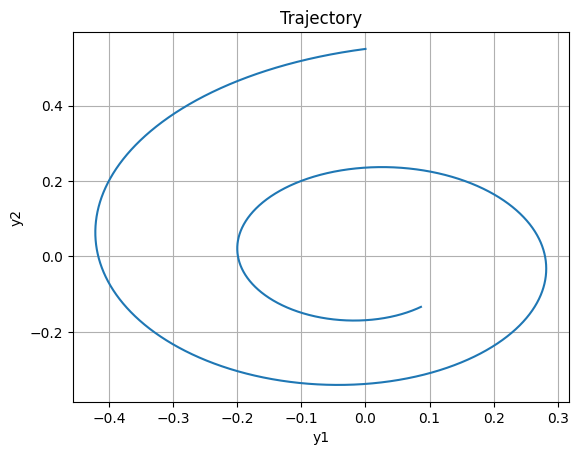

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set the parameters
beta1 = -0.1
beta2 = -0.1
sigma = -1

# Define the system of differential equations
def system(y, t):
    y1, y2 = y[0], y[1]
    y1_dot = beta1 * y1 - y2 + beta2 * y1 * (y1**2 + y2**2) + sigma * y1 * (y1**2 + y2**2)**2
    y2_dot = y1 + beta1 * y2 + beta2 * y2 * (y1**2 + y2**2) + sigma * y2 * (y1**2 + y2**2)**2
    return [y1_dot, y2_dot]

# Set the initial conditions
initial_conditions = [0.0, 0.55]

# Set the time span
t = np.linspace(0, 10, 10000)

# Solve the system of differential equations
solution = np.asarray(odeint(system, initial_conditions, t))

# Extract the solution for y1 and y2
y1 = solution[:, 0]
y2 = solution[:, 1]
y = solution

# Plot the trajectory in 2D space
plt.plot(y1, y2)
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Trajectory')
plt.grid(True)
plt.show()


In [88]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax

In [89]:
# Global parameters
K = 1
D_obs = 4
D_latent = 2

y = np.array([y1,y2])

#1st attempt
#noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#noise2=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#boutin_data = np.transpose(np.vstack((y1,y2,noise1,noise2)))

#2nd attempt
#noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#boutin_data = np.transpose(np.vstack((y1,y2,noise1)))

#3rd attempt
# ny1 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))+y1
# ny2 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))+y2
# boutin_data = np.transpose(np.vstack((y1,y2,ny2,ny2)))

# 4th attempt
boutin_data = np.transpose(np.vstack((y1,y2,y1,y2)))

data = boutin_data

In [90]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)

ELBO: 47993.0: 100%|██████████| 100/100 [00:03<00:00, 30.17it/s]   


In [91]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -28569062469853652.0: 100%|██████████| 100/100 [00:00<00:00, 123.08it/s]


In [92]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, boutin_data)

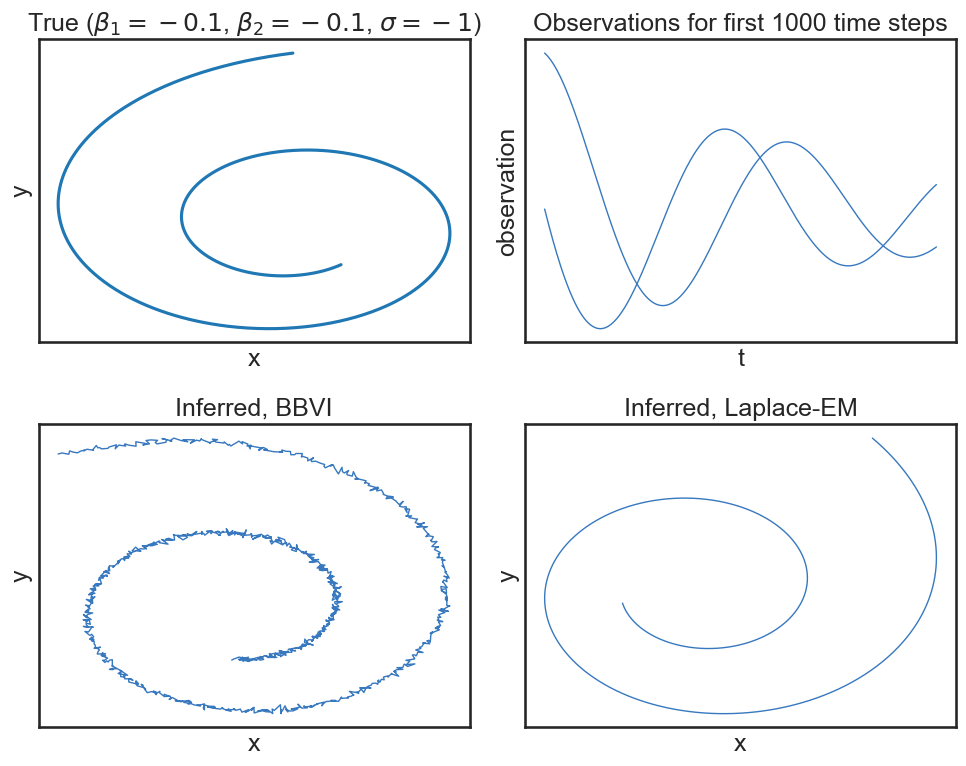

In [93]:
plt.figure(figsize=[10,8])
ax1 = plt.subplot(221)
x=y.T
z=(y1*0).astype(int)

ax1.plot(y1, y2)
plt.title(r"True ($\beta_1=-0.1$, $\beta_2=-0.1$, $\sigma = -1$)")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
ax2 =plt.subplot(222)
plot_observations(z[:8000], boutin_data[:8000,:2], ax=ax2)
plt.title("Observations for first 1000 time steps")
plt.xlabel('t')
plt.ylabel('observation')
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(223)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax3)
plt.title("Inferred, BBVI")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(224)
plot_trajectory(zhat_lem, xhat_lem, ax=ax4)
plt.title("Inferred, Laplace-EM")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])

plt.tight_layout()

## Beta_1 = 0.5 and Beta_2 = 0.5

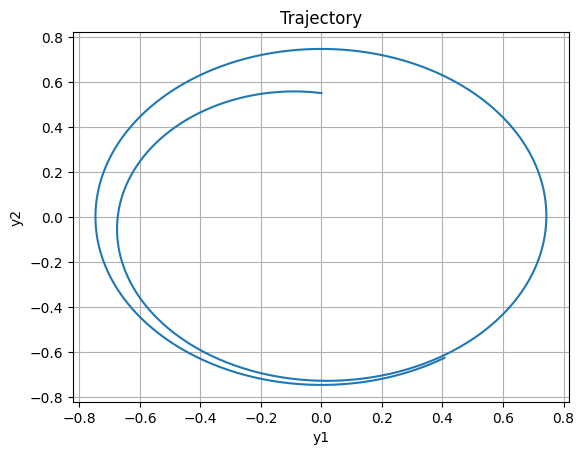

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set the parameters
beta1 = 0.2
beta2 = 0.2
sigma = -1

# Define the system of differential equations
def system(y, t):
    y1, y2 = y[0], y[1]
    y1_dot = beta1 * y1 - y2 + beta2 * y1 * (y1**2 + y2**2) + sigma * y1 * (y1**2 + y2**2)**2
    y2_dot = y1 + beta1 * y2 + beta2 * y2 * (y1**2 + y2**2) + sigma * y2 * (y1**2 + y2**2)**2
    return [y1_dot, y2_dot]

# Set the initial conditions
initial_conditions = [0.0, 0.55]

# Set the time span
t = np.linspace(0, 10, 1000)

# Solve the system of differential equations
solution = np.asarray(odeint(system, initial_conditions, t))

# Extract the solution for y1 and y2
y1 = solution[:, 0]
y2 = solution[:, 1]
y = solution

# Plot the trajectory in 2D space
plt.plot(y1, y2)
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Trajectory')
plt.grid(True)
plt.show()


In [3]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Global parameters
K = 1
D_obs = 4
D_latent = 2

y = np.array([y1,y2])

#1st attempt
#noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#noise2=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#boutin_data = np.transpose(np.vstack((y1,y2,noise1,noise2)))

#2nd attempt
#noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#boutin_data = np.transpose(np.vstack((y1,y2,noise1)))

#3rd attempt
# ny1 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))+y1
# ny2 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))+y2
# boutin_data = np.transpose(np.vstack((y1,y2,ny2,ny2)))

# 4th attempt
boutin_data = np.transpose(np.vstack((y1,y2,y1,y2)))

data = boutin_data

In [7]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
ELBO: nan:   0%|          | 0/100 [00:00<?, ?it/s]


AssertionError: 

In [98]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -78574428575348672.0: 100%|██████████| 100/100 [00:00<00:00, 133.74it/s]


In [99]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, boutin_data)

In [1]:
plt.figure(figsize=[10,8])
ax1 = plt.subplot(221)
x=y.T
z=(y1*0).astype(int)

ax1.plot(y1, y2)
plt.title(r"True ($\beta_1=0.2$, $\beta_2=0.2$, $\sigma = -1$)")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
ax2 =plt.subplot(222)
plot_observations(z[:8000], boutin_data[:8000,:2], ax=ax2)
plt.title("Observations for first 1000 time steps")
plt.xlabel('t')
plt.ylabel('observation')
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(223)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax3)
plt.title("Inferred, BBVI")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(224)
plot_trajectory(zhat_lem, xhat_lem, ax=ax4)
plt.title("Inferred, Laplace-EM")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])

plt.tight_layout()

NameError: name 'plt' is not defined

## Beta_1 = -1/4*Beta_2 and Beta_2 = 1

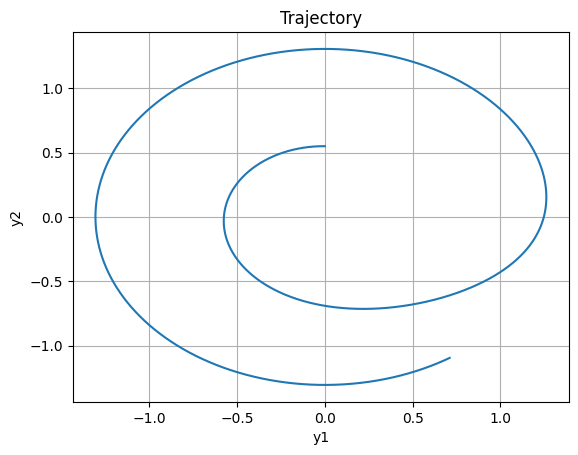

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Set the parameters
beta2 = 2
beta1 = -1/4 * beta2

sigma = -1

# Define the system of differential equations
def system(y, t):
    y1, y2 = y[0], y[1]
    y1_dot = beta1 * y1 - y2 + beta2 * y1 * (y1**2 + y2**2) + sigma * y1 * (y1**2 + y2**2)**2
    y2_dot = y1 + beta1 * y2 + beta2 * y2 * (y1**2 + y2**2) + sigma * y2 * (y1**2 + y2**2)**2
    return [y1_dot, y2_dot]

# Set the initial conditions
initial_conditions = [0.0, .55]

# Set the time span
t = np.linspace(0, 10, 1000)

# Solve the system of differential equations
solution = np.asarray(odeint(system, initial_conditions, t))

# Extract the solution for y1 and y2
y1 = solution[:, 0]
y2 = solution[:, 1]
y = solution

# Plot the trajectory in 2D space
plt.plot(y1, y2)
plt.xlabel('y1')
plt.ylabel('y2')
plt.title('Trajectory')
plt.grid(True)
plt.show()


In [102]:
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
color_names = ["windows blue", "red", "amber", "faded green"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax

In [103]:
# Global parameters
K = 1
D_obs = 4
D_latent = 2

y = np.array([y1,y2])

#1st attempt
#noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#noise2=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#boutin_data = np.transpose(np.vstack((y1,y2,noise1,noise2)))

#2nd attempt
#noise1=np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))
#boutin_data = np.transpose(np.vstack((y1,y2,noise1)))

#3rd attempt
# ny1 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))+y1
# ny2 = np.random.normal(loc=0.0, scale=1.0, size=np.shape(y1))+y2
# boutin_data = np.transpose(np.vstack((y1,y2,ny2,ny2)))

# 4th attempt
boutin_data = np.transpose(np.vstack((y1,y2,y1,y2)))

data = boutin_data

In [104]:
# Fit an rSLDS with its default initialization, using Laplace-EM with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent,
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)
q_elbos_lem, q_lem = rslds.fit(data, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(z, rslds.most_likely_states(xhat_lem, data)))
zhat_lem = rslds.most_likely_states(xhat_lem, data)

# store rslds
rslds_lem = copy.deepcopy(rslds)

ELBO: 44058.7: 100%|██████████| 100/100 [00:03<00:00, 30.22it/s]   


In [105]:
# Fit an rSLDS with its default initialization, using BBVI with a structured variational posterior
rslds = ssm.SLDS(D_obs, K, D_latent, 
             transitions="recurrent_only",
             dynamics="diagonal_gaussian",
             emissions="gaussian_orthog",
             single_subspace=True)
rslds.initialize(data)

q_elbos_bbvi, q_bbvi = rslds.fit(data, method="bbvi",
                                 variational_posterior="meanfield",
                                 initialize=False, num_iters=100)

ELBO: -19637064373278980.0: 100%|██████████| 100/100 [00:00<00:00, 116.61it/s]


In [106]:
# Get the posterior mean of the continuous states
xhat_bbvi = q_bbvi.mean[0]

# Find the permutation that matches the true and inferred states
zhat_bbvi = rslds.most_likely_states(xhat_bbvi, boutin_data)

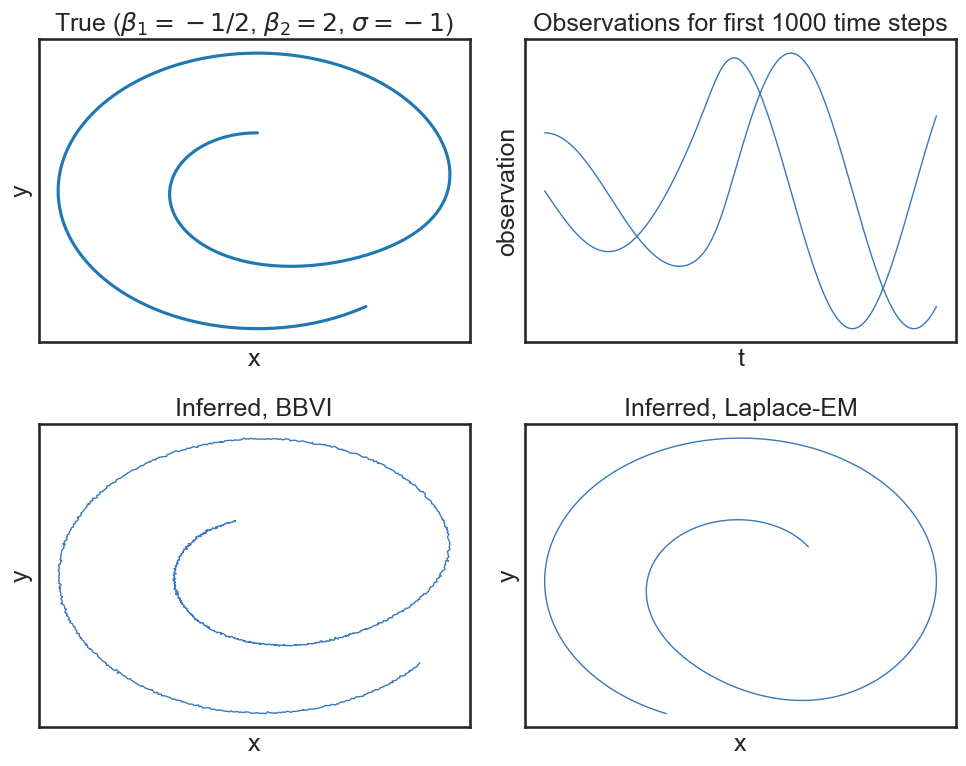

In [108]:
plt.figure(figsize=[10,8])
ax1 = plt.subplot(221)
x=y.T
z=(y1*0).astype(int)

ax1.plot(y1, y2)
plt.title(r"True ($\beta_1=-1/2$, $\beta_2=2$, $\sigma = -1$)")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
ax2 =plt.subplot(222)
plot_observations(z[:8000], boutin_data[:8000,:2], ax=ax2)
plt.title("Observations for first 1000 time steps")
plt.xlabel('t')
plt.ylabel('observation')
plt.xticks([])
plt.yticks([])
ax3 = plt.subplot(223)
plot_trajectory(zhat_bbvi, xhat_bbvi, ax=ax3)
plt.title("Inferred, BBVI")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])
ax4 = plt.subplot(224)
plot_trajectory(zhat_lem, xhat_lem, ax=ax4)
plt.title("Inferred, Laplace-EM")
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([])
plt.yticks([])

plt.tight_layout()